In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 65
HISTORY_SIZE = 50

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

#FRACTION = 0.001
FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL, cs.DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [ ]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64


# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 16
hparams.head_dim = 16
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 200

hparams.use_positional_encoding = False
hparams.use_learned_positions = False

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=False)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 768)
    (dropout): Dropout(p=0.2, inplace=False)
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=768, out_features=256, bias=True)
      (key_proj): Linear(in_features=768, out_features=256, bias=True)
      (value_proj): Linear(in_features=768, out_features=256, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=256, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=256, bias=True)
      (9): ReLU()
      (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_

In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [21]:
from dataloader import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [33]:
print(train_dataloader)
print(len(train_dataloader))


NRMSDataLoader(behaviors=shape: (201, 7)
┌─────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ user_id ┆ impression_i ┆ impression_t ┆ article_id_f ┆ article_ids_ ┆ article_ids_ ┆ labels      │
│ ---     ┆ d            ┆ ime          ┆ ixed         ┆ clicked      ┆ inview       ┆ ---         │
│ u32     ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ list[i8]    │
│         ┆ u32          ┆ datetime[μs] ┆ list[i32]    ┆ list[i64]    ┆ list[i64]    ┆             │
╞═════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ 425689  ┆ 397993366    ┆ 2023-05-19   ┆ [9769743,    ┆ [9772328]    ┆ [9772366,    ┆ [0, 0, … 0] │
│         ┆              ┆ 14:00:45     ┆ 9769765, …   ┆              ┆ 9772099, …   ┆             │
│         ┆              ┆              ┆ 9770592]     ┆              ┆ 9717219]     ┆             │
│ 623191  ┆ 23853081     ┆ 2023-05-23   ┆ [9757474

In [ ]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    first_batch = True
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title = data


        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)  
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1/10, Train Batch 1/4: Loss = 0.0129
Epoch 1/10, Train Batch 2/4: Loss = 0.0378
Epoch 1/10, Train Batch 3/4: Loss = 0.0146
Epoch 1/10, Train Batch 4/4: Loss = 0.0016
Epoch 1/10, Val Batch 1/1: Loss = 0.2317
Epoch 1/10: Train Loss = 0.0167, Val Loss = 0.2317
Epoch 2/10, Train Batch 1/4: Loss = 0.0116
Epoch 2/10, Train Batch 2/4: Loss = 0.0306
Epoch 2/10, Train Batch 3/4: Loss = 0.0172
Epoch 2/10, Train Batch 4/4: Loss = 0.0001
Epoch 2/10, Val Batch 1/1: Loss = 0.2312
Epoch 2/10: Train Loss = 0.0149, Val Loss = 0.2312
Epoch 3/10, Train Batch 1/4: Loss = 0.0097
Epoch 3/10, Train Batch 2/4: Loss = 0.0409
Epoch 3/10, Train Batch 3/4: Loss = 0.0160
Epoch 3/10, Train Batch 4/4: Loss = 0.0001
Epoch 3/10, Val Batch 1/1: Loss = 0.2306
Epoch 3/10: Train Loss = 0.0167, Val Loss = 0.2306
Epoch 4/10, Train Batch 1/4: Loss = 0.0096
Epoch 4/10, Train Batch 2/4: Loss = 0.0297
Epoch 4/10, Train Batch 3/4: Loss = 0.0198
Epoch 4/10, Train Batch 4/4: Loss = 0.0000
Epoch 4/10, Val Batch 1/1: Loss = 0.

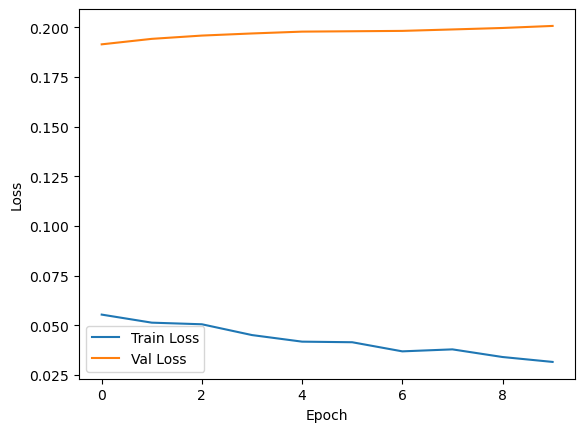

In [17]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():  
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) 
        loss = criterion(outputs, labels)                 
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test Batch {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)
        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test Batch 1/26: Loss = 0.2117
Test Batch 2/26: Loss = 0.2125
Test Batch 3/26: Loss = 0.2741
Test Batch 4/26: Loss = 0.2769
Test Batch 5/26: Loss = 0.1848
Test Batch 6/26: Loss = 0.2069
Test Batch 7/26: Loss = 0.1994
Test Batch 8/26: Loss = 0.2058
Test Batch 9/26: Loss = 0.2162
Test Batch 10/26: Loss = 0.1929
Test Batch 11/26: Loss = 0.1950
Test Batch 12/26: Loss = 0.2508
Test Batch 13/26: Loss = 0.2306
Test Batch 14/26: Loss = 0.1887
Test Batch 15/26: Loss = 0.1795
Test Batch 16/26: Loss = 0.2366
Test Batch 17/26: Loss = 0.2109
Test Batch 18/26: Loss = 0.2322
Test Batch 19/26: Loss = 0.2544
Test Batch 20/26: Loss = 0.1384
Test Batch 21/26: Loss = 0.2550
Test Batch 22/26: Loss = 0.2356
Test Batch 23/26: Loss = 0.2478
Test Batch 24/26: Loss = 0.1822
Test Batch 25/26: Loss = 0.2760
Test Batch 26/26: Loss = 0.3053
Test loss: 0.22307931861052147
[[0.29584386944770813, 0.5446489453315735, 0.005004341714084148, 0.14576666057109833, 0.00873615499585867], [0.9548020362854004, 0.021086882799863

AUC: 100%|█████████████████████████████████| 255/255 [00:00<00:00, 33953.89it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.55,
    "mrr": 0.49457516339869284,
    "ndcg@5": 0.6188365966629619,
    "ndcg@10": 0.6188365966629619
}


In [19]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.047 vs 1.000
0.236 vs 0.000
0.028 vs 0.000
0.151 vs 0.000
0.538 vs 0.000

Article 1
0.020 vs 1.000
0.062 vs 0.000
0.037 vs 0.000
0.036 vs 0.000
0.846 vs 0.000

Article 2
0.018 vs 1.000
0.268 vs 0.000
0.268 vs 0.000
0.224 vs 0.000
0.223 vs 0.000

Article 3
0.181 vs 1.000
0.262 vs 0.000
0.148 vs 0.000
0.262 vs 0.000
0.148 vs 0.000

Article 4
0.007 vs 0.000
0.251 vs 0.000
0.009 vs 0.000
0.662 vs 0.000
0.072 vs 1.000

Article 5
0.030 vs 0.000
0.004 vs 0.000
0.201 vs 0.000
0.484 vs 0.000
0.281 vs 1.000

Article 6
0.023 vs 0.000
0.004 vs 1.000
0.475 vs 0.000
0.475 vs 0.000
0.023 vs 0.000

Article 7
0.244 vs 1.000
0.038 vs 0.000
0.255 vs 0.000
0.365 vs 0.000
0.099 vs 0.000

Article 8
0.089 vs 0.000
0.535 vs 0.000
0.353 vs 0.000
0.014 vs 1.000
0.009 vs 0.000

Article 9
0.011 vs 0.000
0.170 vs 0.000
0.229 vs 1.000
0.379 vs 0.000
0.211 vs 0.000

Article 10
0.059 vs 1.000
0.063 vs 0.000
0.191 vs 0.000
0.496 vs 0.000
0.191 vs 0.000

Article 11
0.088 vs 0.0

Confusion Matrix:
[[930  90]
 [219  36]]


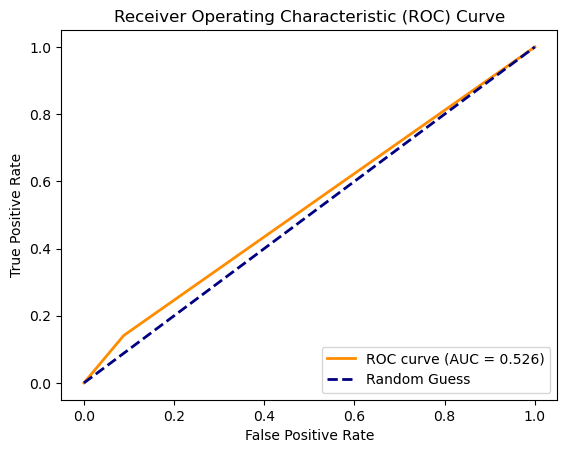

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()